In [1]:
from __future__ import division
import numpy as np
import json
import re
import gzip
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns
import datetime
from ethiopian_date import ethiopian_date
from collections import defaultdict
import os 
from matplotlib.colors import LogNorm

# Plotting code
from plot_util import *

# Modeles:

from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


<h1> Functions </h1>

In [111]:
def plot_nation_rmse(tests, target, end_date, savedir=None):
    rmse_data = {}
    fig=figure()
    fig.set_size_inches(8, 6)
    
    for i in range(1, len(tests)):
        pred_text = 'prediction_m_%s' % (i*6)
        DF_testing = pd.concat(tests[i], ignore_index=True)
        DF_testing = DF_testing[DF_testing['E_Date'] < end_date]

        # Sum over all the regions that make up the national indicator... after the sum, groupby by level 0
        nation_rmse = DF_testing.groupby(['Indicator', 'Real_Date']).sum()\
            .groupby(level=0).apply(lambda x: np.sqrt((((x[target] - x[pred_text]) / x[target])**2).mean()))

        nation_rmse.index = [val.split('malaria')[-1] for val in nation_rmse.index]
        nation_rmse.plot.bar(color='r', alpha=0.5)
        rmse_data.update({'nation_rmse_m%s' % (i*6): nation_rmse})

        if savedir:
            plt.savefig('%s/Nation_RMSE_m%s.png' % (savedir, (i*6)))

    return rmse_data

def plot_region_rmse(tests, target, end_date, savedir=None):
    rmse_data = {}
    for i in range(1, len(tests)):
        pred_text = 'prediction_m_%s' % (i*6)
        DF_testing = pd.concat(tests[i], ignore_index=True)
        DF_testing = DF_testing[DF_testing['E_Date'] < end_date]
        
        fig=figure()
        fig.set_size_inches(8, 6)

        # Sum over all the regions that make up the national indicator... after the sum, groupby by level 0
        region_rmse = DF_testing.replace(0,1).groupby(['Region', 'Indicator'])\
            .apply(lambda x: np.sqrt((((x[target] - x[pred_text]) / x[target])**2).mean()))

        result = region_rmse.reset_index().pivot(index='Region', columns='Indicator', values=0).replace(np.nan,0)
        result.columns=[val.split('malaria')[-1] for val in result.columns]
        
        sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
        sns.heatmap(result, annot=True, fmt=".2f", cmap='viridis', label='big',\
                    square=False,linewidths=0.1, cbar=False, norm=LogNorm(vmin=result.min(), vmax=result.max()))
        plt.title(pred_text)
        rmse_data.update({'region_rmse_m%s' % (i*6): region_rmse})
        
        if savedir:
            plt.savefig('%s/Region_RMSE_m%s.png' % (savedir, (i*6)))
    return rmse_data

def plot_feature_imp(feature_imp, ylog=False):
    figure()
    sorted_index = sorted(range(len(feature_imp)),key=lambda x:feature_imp[x], reverse=True)
    xx = range(len(feature_imp))
    plt.bar(xx, feature_imp[sorted_index])
    xticks(xx, [features[i] for i in sorted_index], rotation = 'vertical')
    ylabel('Feature Importance')
    if ylog:
        yscale('log')
        
def generate_shifts(columns, months=1, width=3):
    name_maps = {}
    for column in columns:
        for i, j in enumerate(range(months, 2*months + width)):
            original_name = column if i==0 else '%s_shift_%s' % (column, i)
            new_name = '%s_shift_%s' % (column, j)
            name_maps.update({original_name: new_name})
    return name_maps

def add_rmse(dataframe, region_rmse):
    # Using the rmse calculated from model 12 months ago
    rmse_df = pd.DataFrame(region_rmse['region_rmse_m12']).reset_index().rename(columns= {0: 'rmse'})
    return dataframe.merge(rmse_df, how='left', on=['Region', 'Indicator'])

def check_neg(predictions):
    return np.array([int(pred) if pred >= 0 else 1 for pred in predictions])

<h1> Functions to run forecasts </h1>

In [58]:
def load_data(filepath = 'Malaria_regional_3-24-2017.csv'):
    DF_ind = pd.read_csv(filepath, index_col=0).reset_index(drop=True)

    # Convert string to datetime
    DF_ind['Real_Date'] = pd.to_datetime(DF_ind['Real_Date'])
    DF_ind['E_Date'] = pd.to_datetime(DF_ind['E_Date'])
    # list of indicator names
    indicators = DF_ind['Indicator'].unique()
    regions = DF_ind['Region'].unique()
    return DF_ind, indicators, regions

def setup_prediction_interval(dataframe, months=1):
    cols_to_shift = ['val', 'log_val', 'sg_val', 'log_sg_val', 'infection_rate', 'Region', 'Indicator']
    for i in range(1, 3 + months):
        suffixes = ('', '_shift_%s' % i)
        dataframe = dataframe.merge(dataframe[cols_to_shift].shift(i), left_index=True, right_index=True, how='left', suffixes=suffixes)

    return dataframe[(dataframe['Region'] == dataframe['Region_shift_%s' % i]) & \
                    (dataframe['Indicator'] == dataframe['Indicator_shift_%s' % i])]

In [170]:
# Constants 
EMONTH_LIST = ['is_emonth_%s' % i for i in range(1, 13)]
GENDER_AGE_INFO = ['is_male_child', 'is_female_child', 'is_male_teen', 'is_female_teen', 'is_male_adult']
REGION_INFO = ['net_frac', 'pop', 'minElevation_m', 'Elevation_m', 'Area_km2', 'density']
TARGET = 'val'
PRED_SHIFTS = range(0, 13, 6)

def zenprophet(DF_shift, MODEL, end_date, months=1, width=3):
    val_max = months + width
    w_max = months + width
    val_range = range(months, val_max)
    w_range = range(months, w_max)
    
    # Setup historical values to add to the dataframe
    precip_list = ['precipitation_shift_%s' % i for i in w_range]
    days_precip_list = ['days_precipitation_shift_%s' % i for i in w_range]
    wind_list = ['wind_avg_shift_%s' % i for i in w_range]
    temp_list = ['temp_min_shift_%s' % i for i in w_range]
    temp_list = ['temp_max_shift_%s' % i for i in w_range]
    humid_list = ['humid_avg_shift_%s' % i for i in w_range]
    solar_list = ['solar_shift_%s' % i for i in w_range]
    val_list = ['sg_val_shift_%s' % i for i in val_range]
    infec_rate_list = ['infection_rate_shift_%s' % i for i in val_range]

    features = EMONTH_LIST + REGION_LIST +  precip_list + wind_list + temp_list + humid_list \
                    + solar_list + val_list + infec_rate_list + REGION_INFO + GENDER_AGE_INFO
    print features

    trains = defaultdict(list)
    tests = defaultdict(list)
    shifts = []
    preds = []

    for region_group in REGION_GROUPS:
        region_cut = [region in region_group for region in DF_shift['Region']]
        DF_shift_region = DF_shift[region_cut].copy()
        DF_shift_region_cut = DF_shift[region_cut].copy()

        for i, offset in enumerate(PRED_SHIFTS):
            DF_training = DF_shift_region_cut[DF_shift_region_cut['E_Date'] < \
                        end_date - pd.offsets.relativedelta(months=offset)]
            DF_testing = DF_shift_region_cut.drop(DF_training.index)

            poststr = ''
            if offset != 0:
                poststr = '_m_%s' % offset
            prediction_str = 'prediction%s' % poststr

            # Training:
            y = DF_training[TARGET].values
            xtrain = DF_training[features].values
            MODEL.fit(xtrain, y)
            #plot_feature_imp(RF.coef_)

            DF_training[prediction_str] = check_neg(MODEL.predict(xtrain))
            trains[i].append(DF_training)

            # Testing:
            xtest = DF_testing[features].values
            DF_testing[prediction_str] = check_neg(MODEL.predict(xtest))
            tests[i].append(DF_testing)

            #Make predictions one month forward
            x_all = DF_shift_region[features].values
            DF_shift_region[prediction_str] = check_neg(MODEL.predict(x_all))

            if i==0:
                preds.append(make_prediction(DF_shift_region, MODEL, end_date, features, months))
            
        shifts.append(DF_shift_region)
        
    DF_shift_all = pd.concat(shifts, ignore_index=True)
    preds_all = pd.concat(preds, ignore_index=True)
    #Tack on RMSE, from model trained 12 months ago
    region_rmse = plot_region_rmse(tests, TARGET, end_date, savedir=None)
    return add_rmse(DF_shift_all, region_rmse), add_rmse(preds_all, region_rmse)

In [108]:
def make_prediction(DF_shift, MODEL, end_date, features, months):
    things_to_shift = ['val'] + list({feature.split('_shift')[0] for feature in features if '_shift' in feature})

    last_rows = DF_shift[DF_shift['E_Date'] == end_date].reset_index()
    last_rows.rename(columns=generate_shifts(things_to_shift, months), inplace=True)
    last_rows['E_Date'] = last_rows['E_Date'].apply(lambda x: x + pd.offsets.relativedelta(months=months))
    # replace Real_Date with incremented E_Date 
    last_rows['Real_Date'] = [ethiopian_date.EthiopianDateConverter.date_to_gregorian(date) for date in last_rows['E_Date']]
    last_rows['E_year'] = [val.year for val in last_rows['E_Date']]
    last_rows['E_month'] = [val.month for val in last_rows['E_Date']]
    last_rows['month'] = [val.year for val in last_rows['Real_Date']]
    last_rows['year'] = [val.year for val in last_rows['Real_Date']]
    # Update onehot month
    cur_emonth = last_rows['E_month'].max()
    for onehot_month in EMONTH_LIST:
        if int(onehot_month.split('_')[-1]) == cur_emonth:
            last_rows[onehot_month] = 1
        else:
            last_rows[onehot_month] = 0
    # Make predictions:
    x_forecast = last_rows[features].values
    last_rows['prediction'] = check_neg(MODEL.predict(x_forecast))
    return last_rows

<h1> Main </h1>

['is_emonth_1', 'is_emonth_2', 'is_emonth_3', 'is_emonth_4', 'is_emonth_5', 'is_emonth_6', 'is_emonth_7', 'is_emonth_8', 'is_emonth_9', 'is_emonth_10', 'is_emonth_11', 'is_emonth_12', 'is_afar', 'is_amhara', 'is_dire dawa', 'is_benishangul-gumuz', 'is_addis ababa', 'is_somali', 'is_oromiya', 'is_harari', 'is_snnpr', 'is_tigray', 'is_gambella', 'precipitation_shift_1', 'precipitation_shift_2', 'precipitation_shift_3', 'wind_avg_shift_1', 'wind_avg_shift_2', 'wind_avg_shift_3', 'temp_max_shift_1', 'temp_max_shift_2', 'temp_max_shift_3', 'humid_avg_shift_1', 'humid_avg_shift_2', 'humid_avg_shift_3', 'solar_shift_1', 'solar_shift_2', 'solar_shift_3', 'sg_val_shift_1', 'sg_val_shift_2', 'sg_val_shift_3', 'infection_rate_shift_1', 'infection_rate_shift_2', 'infection_rate_shift_3', 'net_frac', 'pop', 'minElevation_m', 'Elevation_m', 'Area_km2', 'density', 'is_male_child', 'is_female_child', 'is_male_teen', 'is_female_teen', 'is_male_adult']


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['is_emonth_1', 'is_emonth_2', 'is_emonth_3', 'is_emonth_4', 'is_emonth_5', 'is_emonth_6', 'is_emonth_7', 'is_emonth_8', 'is_emonth_9', 'is_emonth_10', 'is_emonth_11', 'is_emonth_12', 'is_afar', 'is_amhara', 'is_dire dawa', 'is_benishangul-gumuz', 'is_addis ababa', 'is_somali', 'is_oromiya', 'is_harari', 'is_snnpr', 'is_tigray', 'is_gambella', 'precipitation_shift_2', 'precipitation_shift_3', 'precipitation_shift_4', 'wind_avg_shift_2', 'wind_avg_shift_3', 'wind_avg_shift_4', 'temp_max_shift_2', 'temp_max_shift_3', 'temp_max_shift_4', 'humid_avg_shift_2', 'humid_avg_shift_3', 'humid_avg_shift_4', 'solar_shift_2', 'solar_shift_3', 'solar_shift_4', 'sg_val_shift_2', 'sg_val_shift_3', 'sg_val_shift_4', 'infection_rate_shift_2', 'infection_rate_shift_3', 'infection_rate_shift_4', 'net_frac', 'pop', 'minElevation_m', 'Elevation_m', 'Area_km2', 'density', 'is_male_child', 'is_female_child', 'is_male_teen', 'is_female_teen', 'is_male_adult']
['is_emonth_1', 'is_emonth_2', 'is_emonth_3', 'is_e

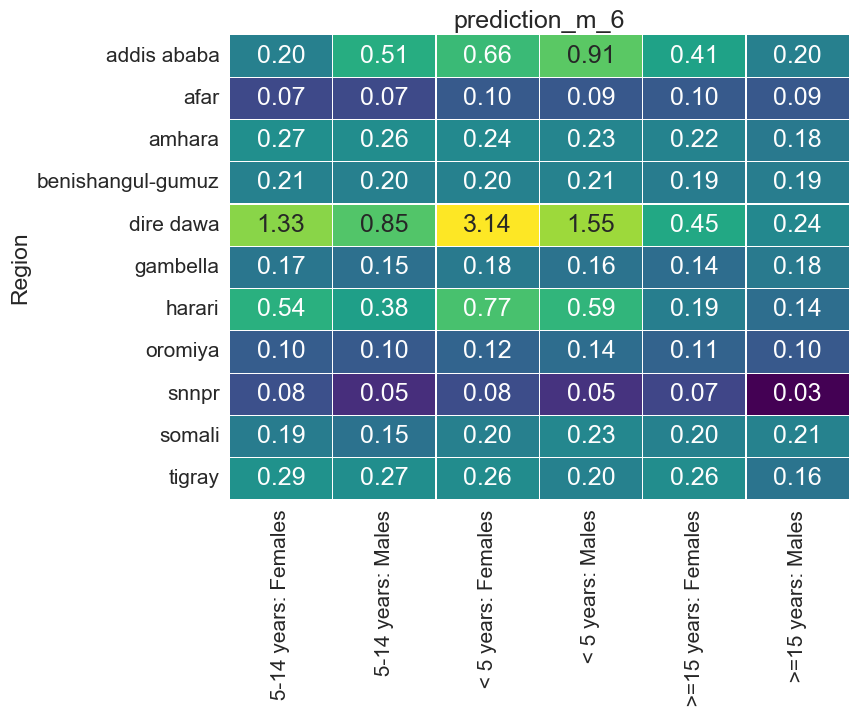

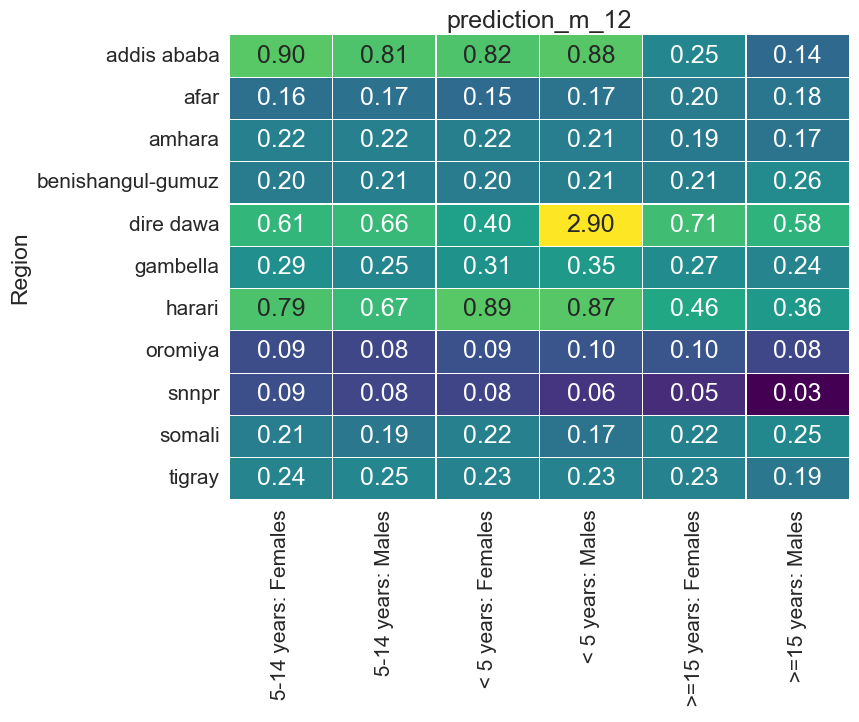

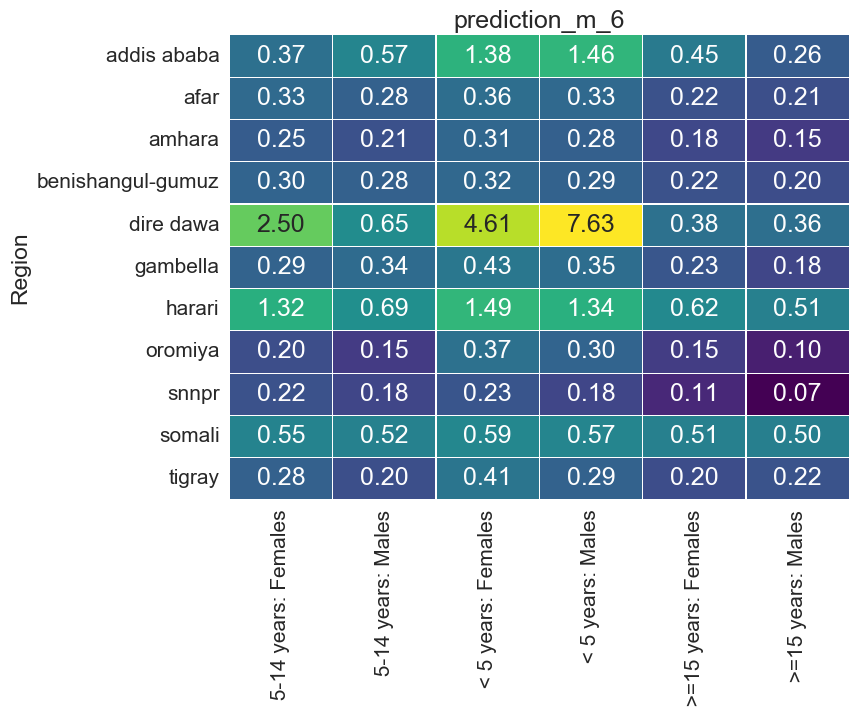

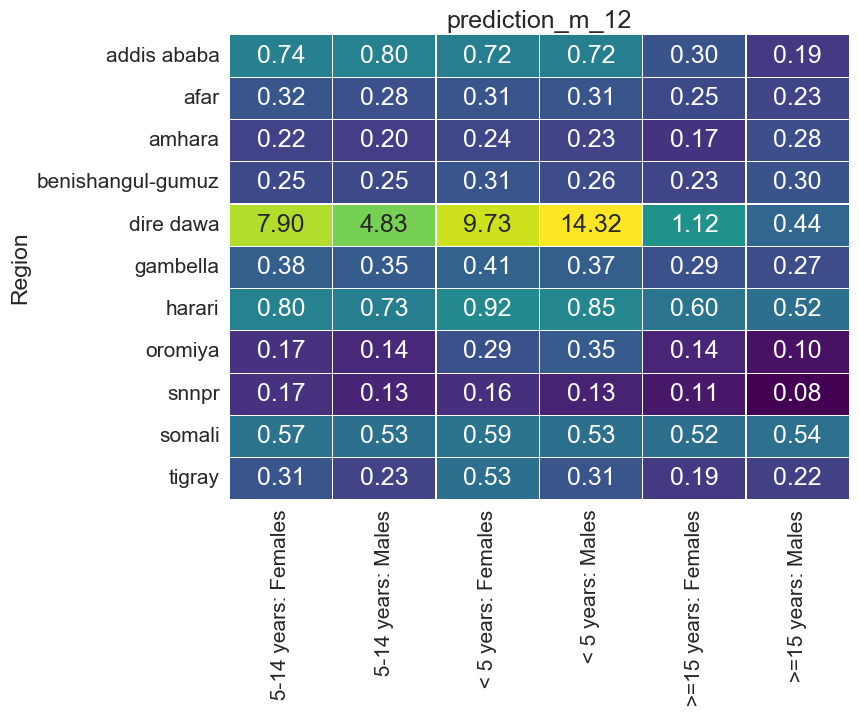

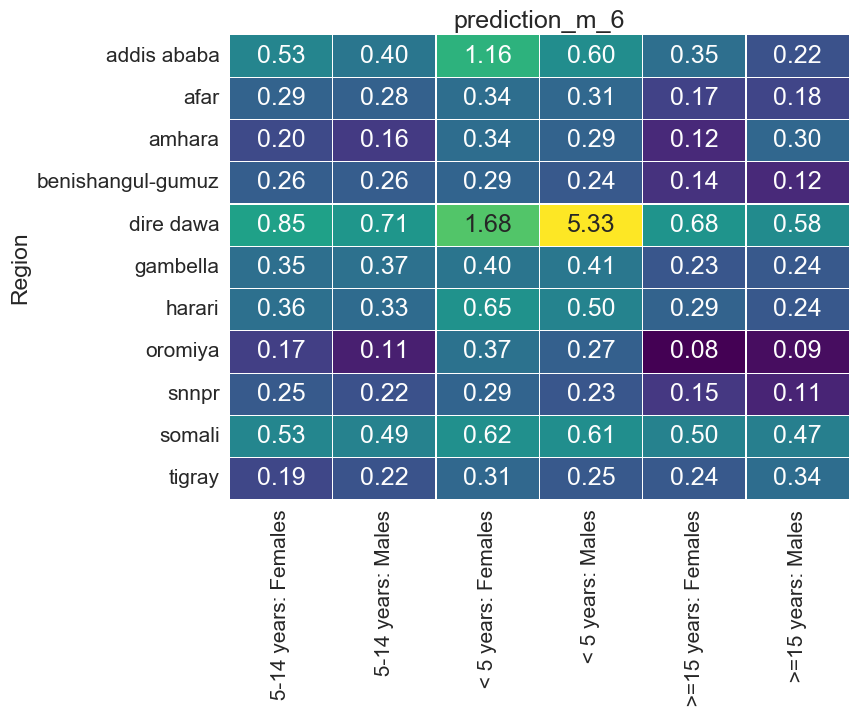

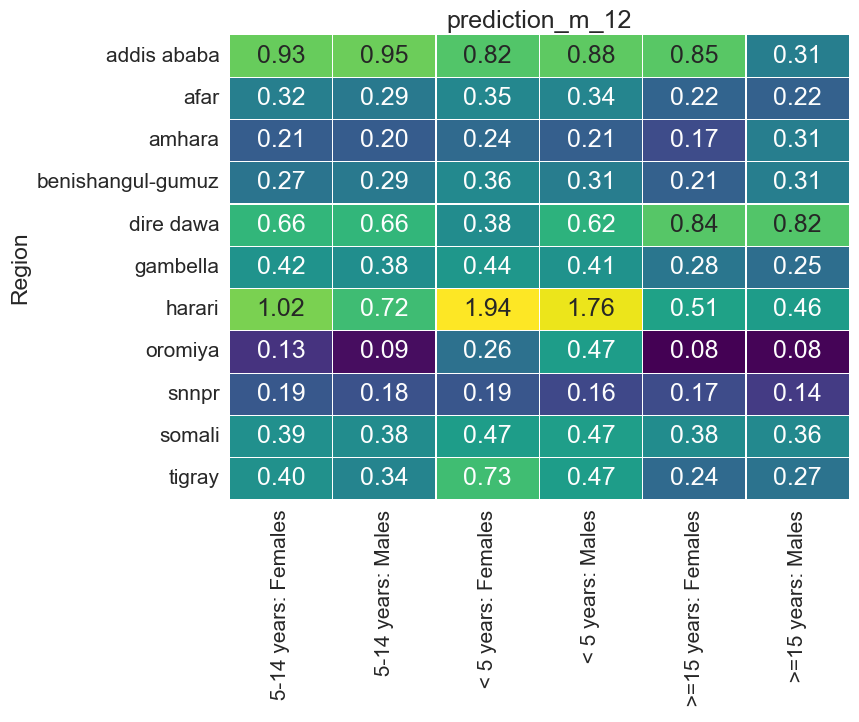

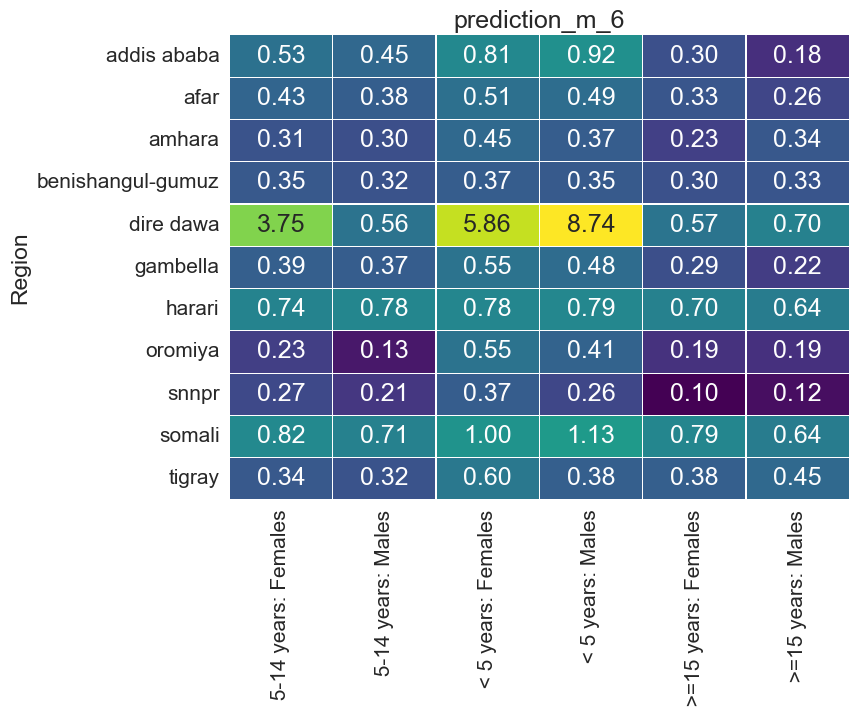

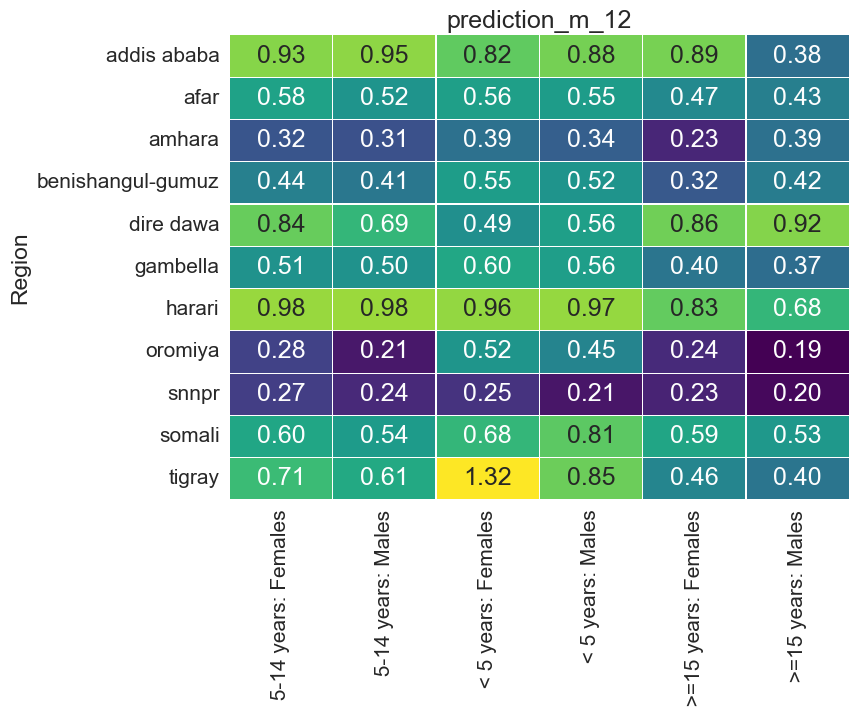

In [113]:
MODEL = BayesianRidge(n_iter=300)
dataframe, indicators, regions = load_data()

REGION_LIST = ['is_%s' % region for region in regions]
# Setup region groups
addis = ['addis ababa']
dire = ['dire dawa']
harari = ['harari']
others = [region for region in regions if region not in addis + dire + harari]
REGION_GROUPS = [addis, dire, harari, others]

# Start forecast 1 month prior, in case there is poor reporting in the current month
end_date = dataframe['E_Date'].max() - pd.offsets.relativedelta(months=1)

def predict_n_months(dataframe, MODEL, end_date, months=1):
    dataframes, predictions = [], []
    for month in range(1, months+1):
        DF_shift = setup_prediction_interval(dataframe, months=month)
        # Run for one n month shift:
        DF_shift_all, preds_all = zenprophet(DF_shift, MODEL, end_date, months=month)
        dataframes.append(DF_shift_all)
        predictions.append(preds_all)
    return dataframes, predictions
        
dataframes, predictions = predict_n_months(dataframe, MODEL, end_date, months=4)

In [146]:
# One was porduced for each forecast amount
good_columns = ['Real_Date', 'E_Date', 'Region', 'Indicator', 'prediction', 'rmse']
testing_df = pd.concat(dataframes, ignore_index=True)
prediction_df = pd.concat([prediction[good_columns] for prediction in predictions], join='inner', ignore_index=True)
prediction_df.set_index('Region', inplace=True)

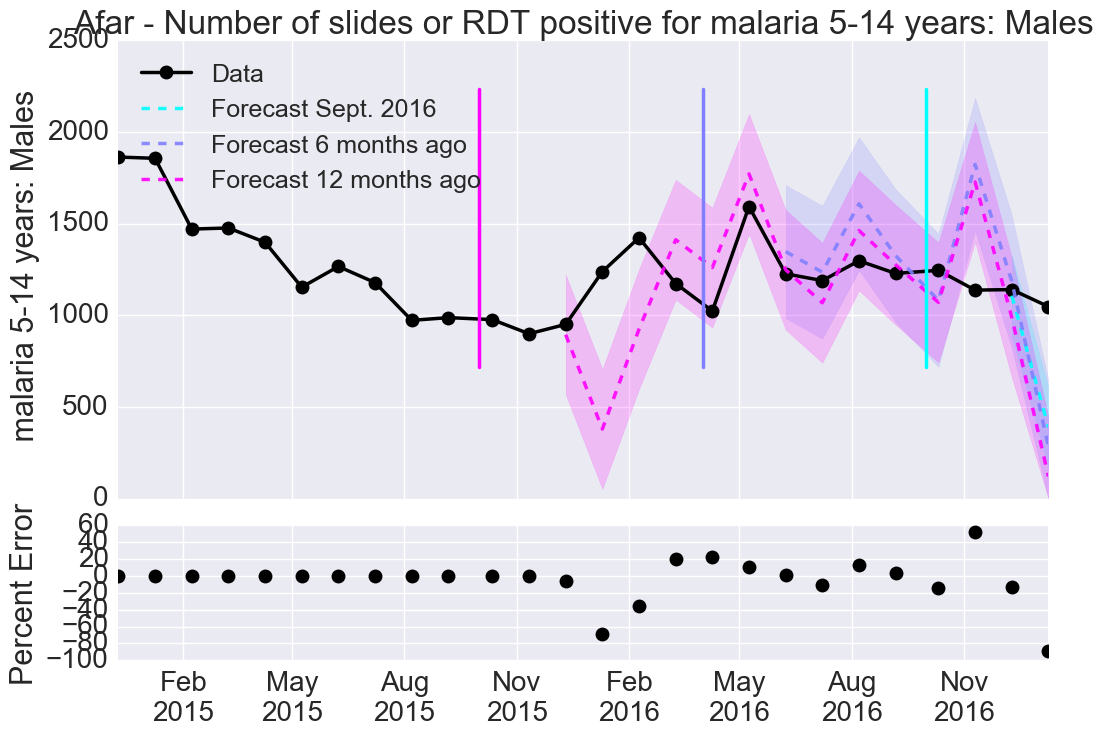

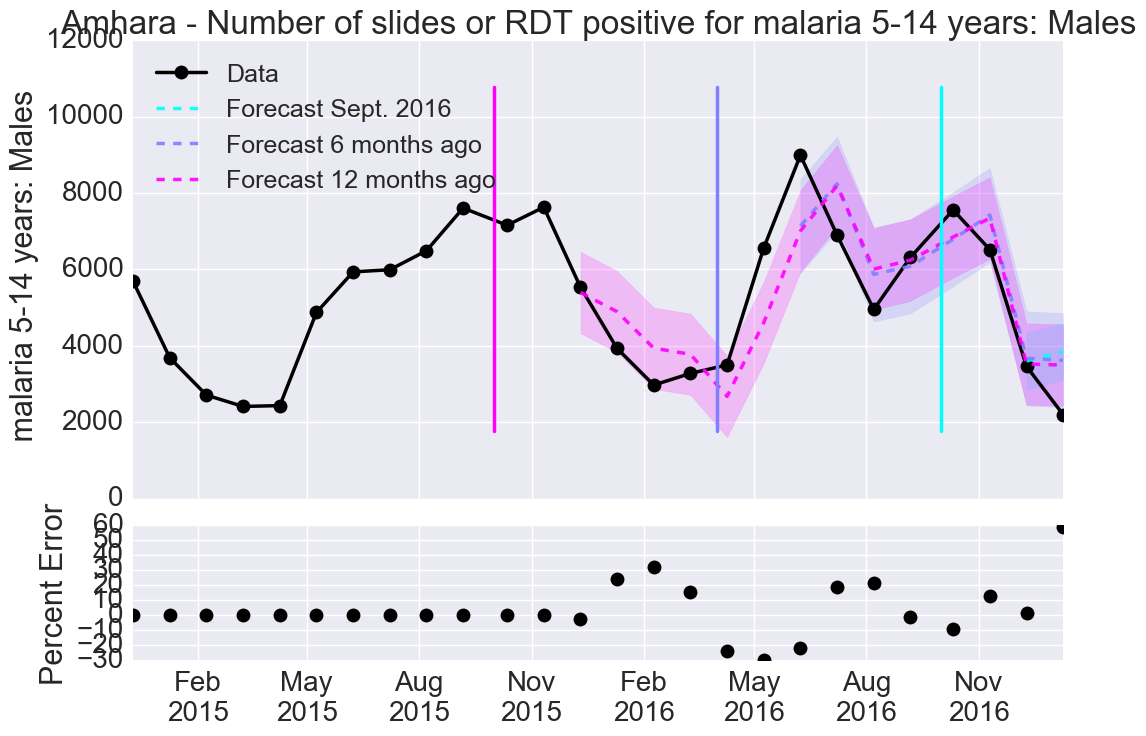

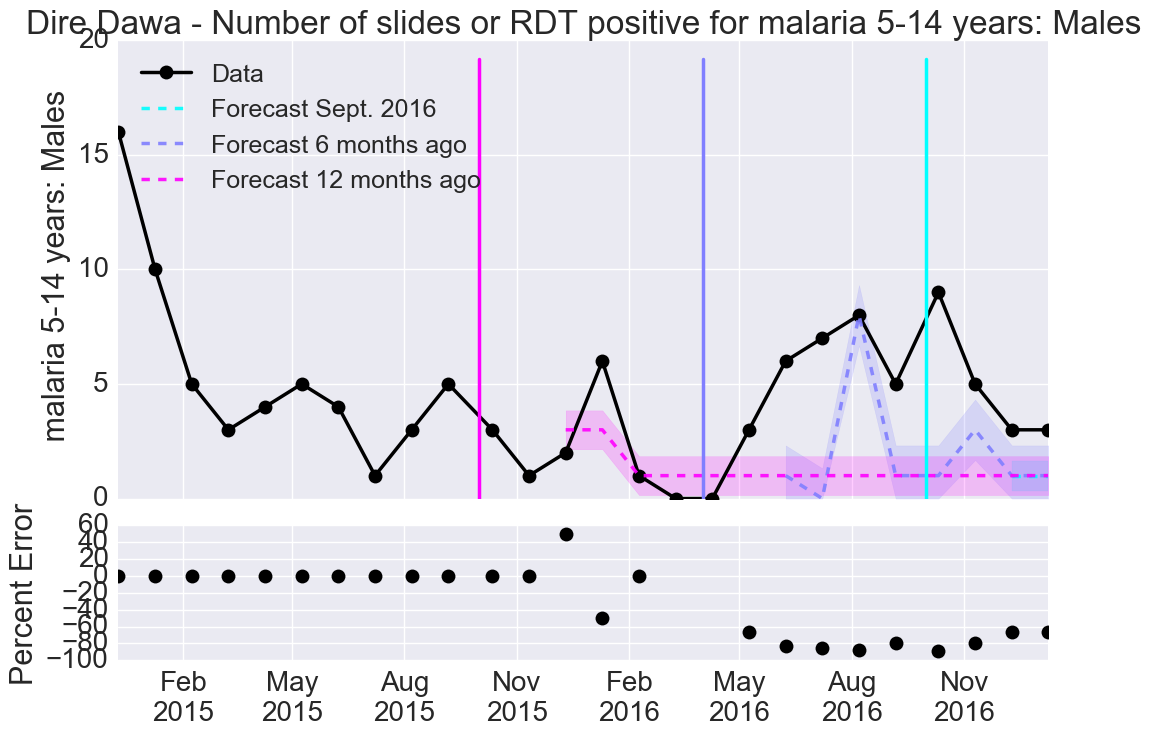

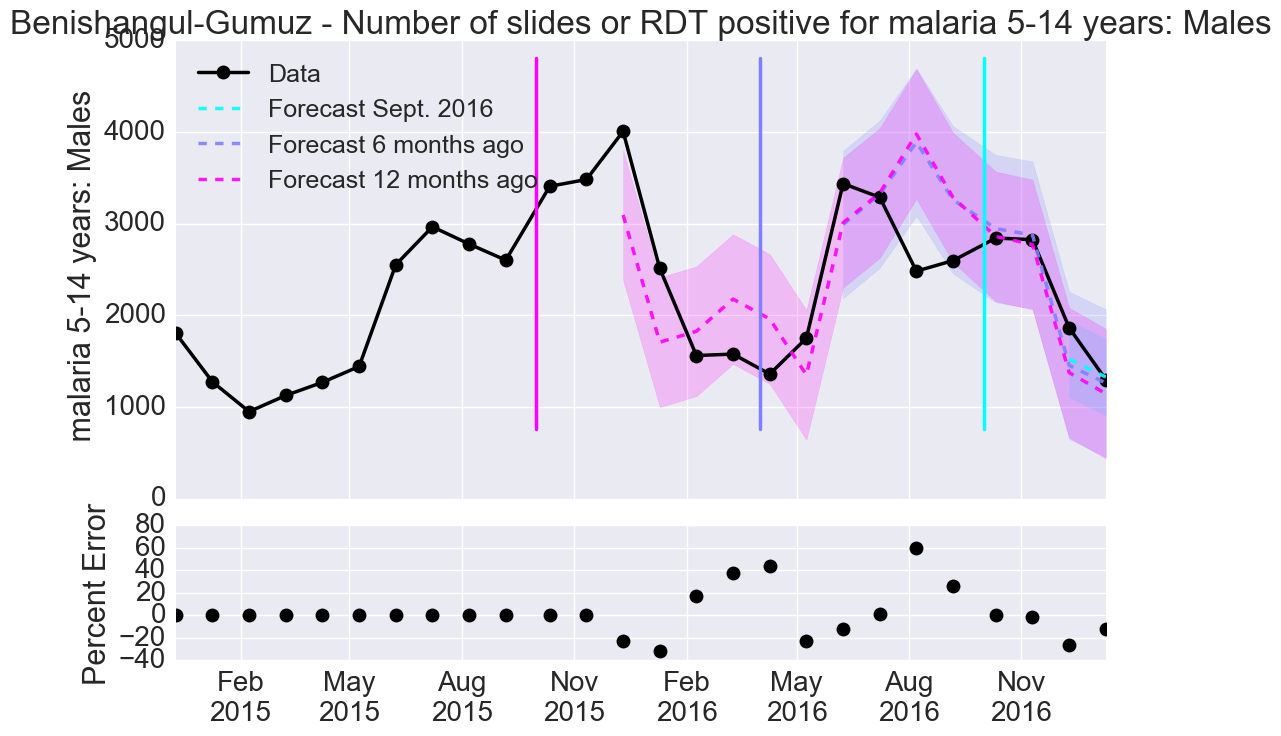

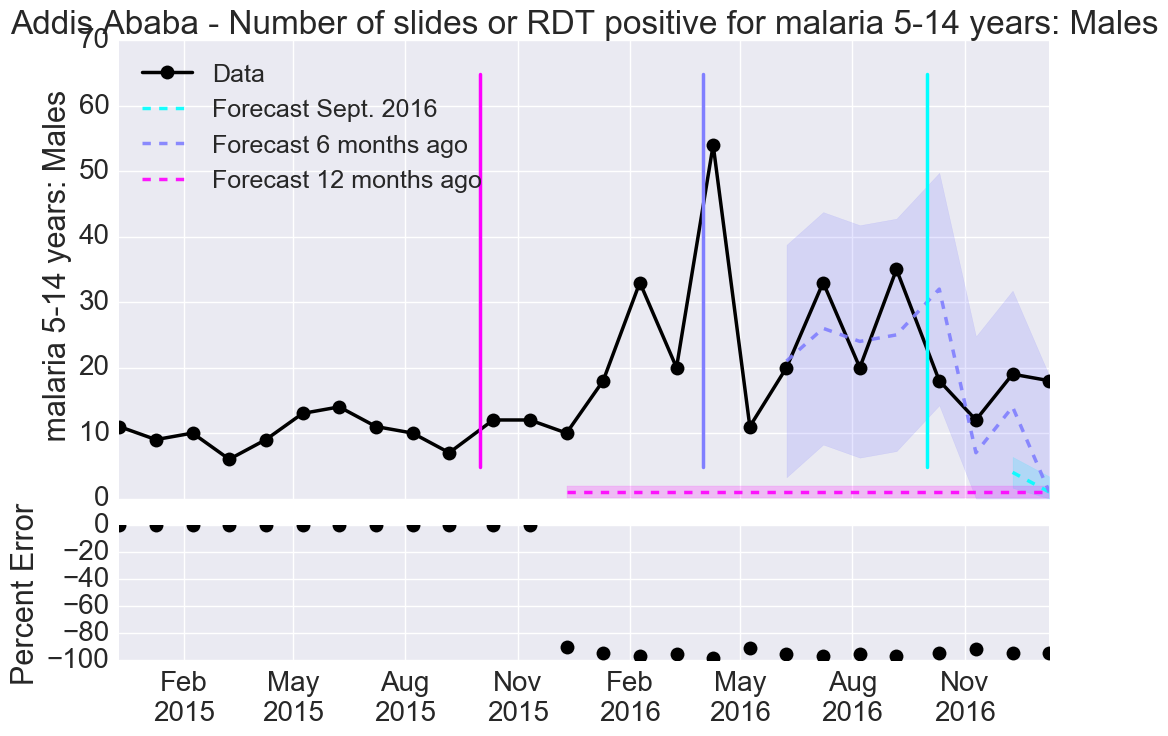

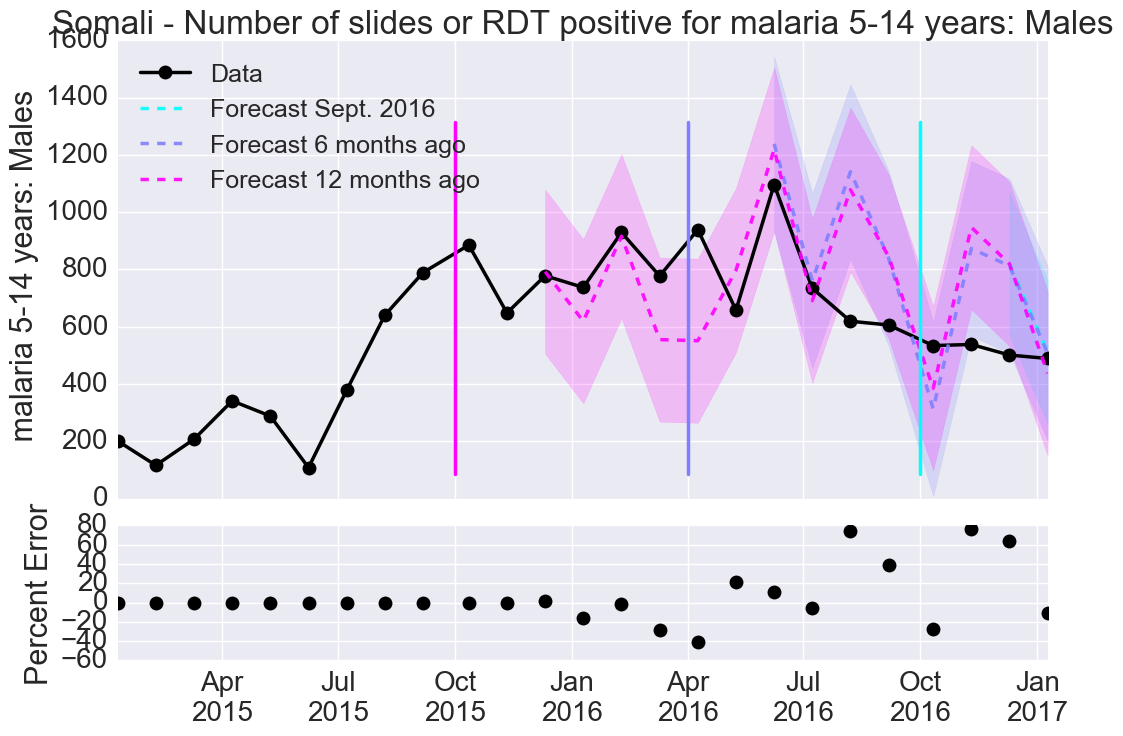

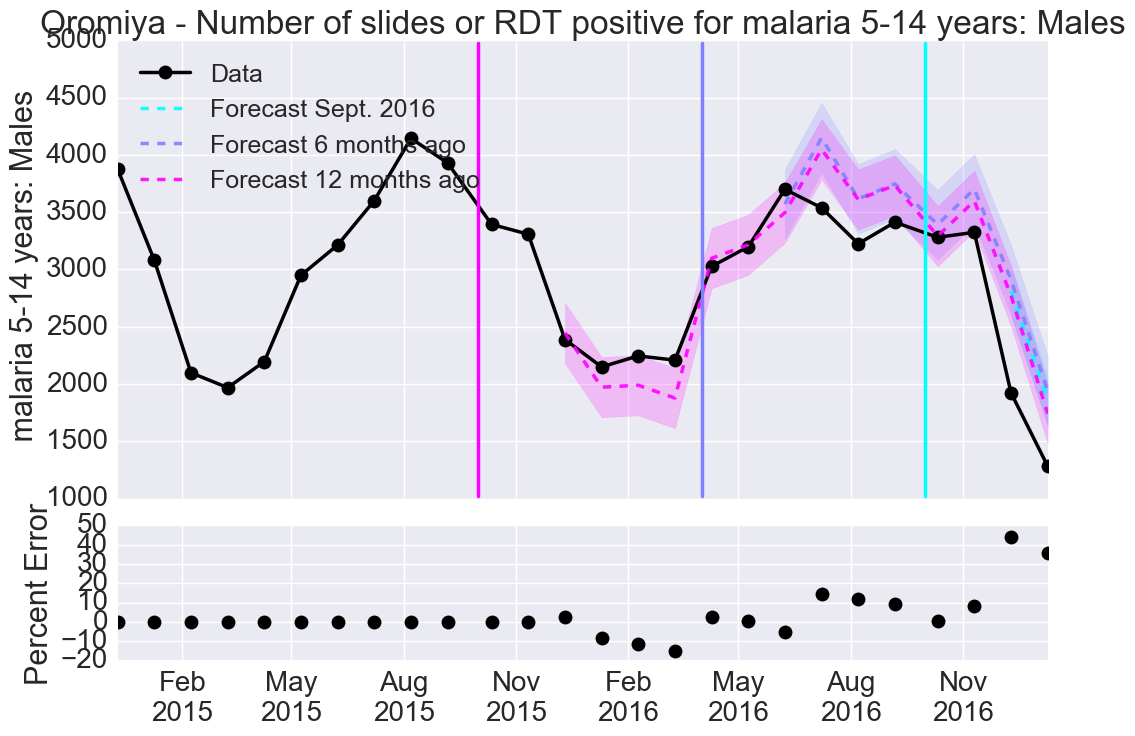

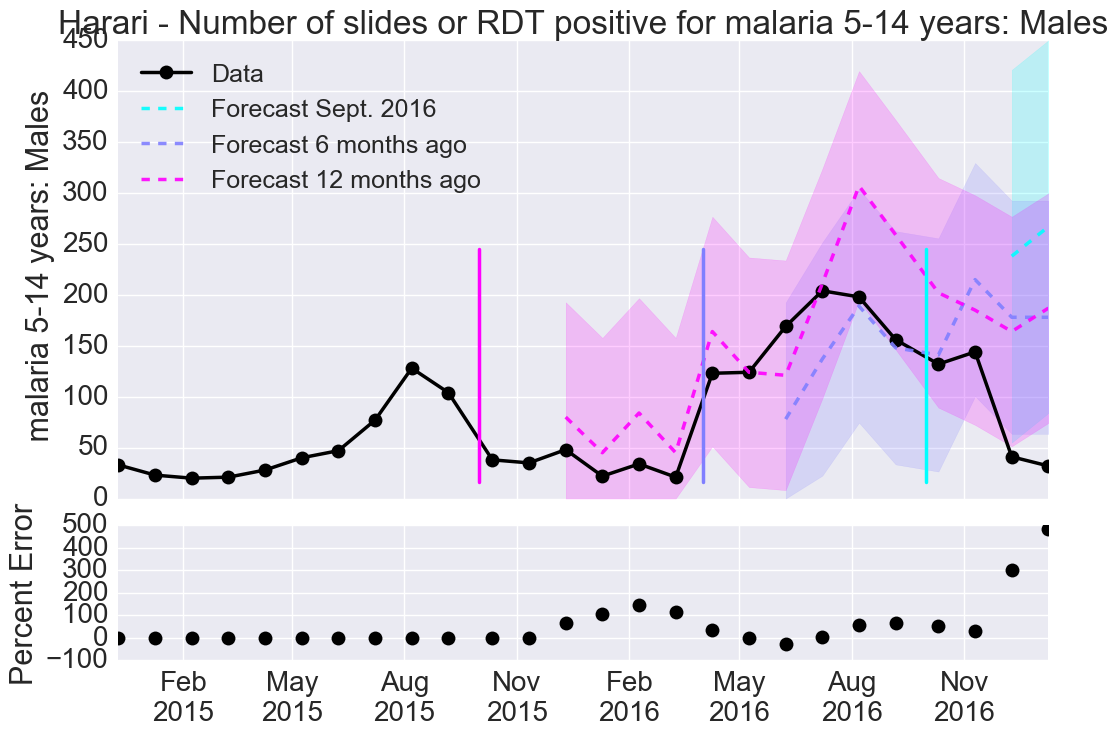

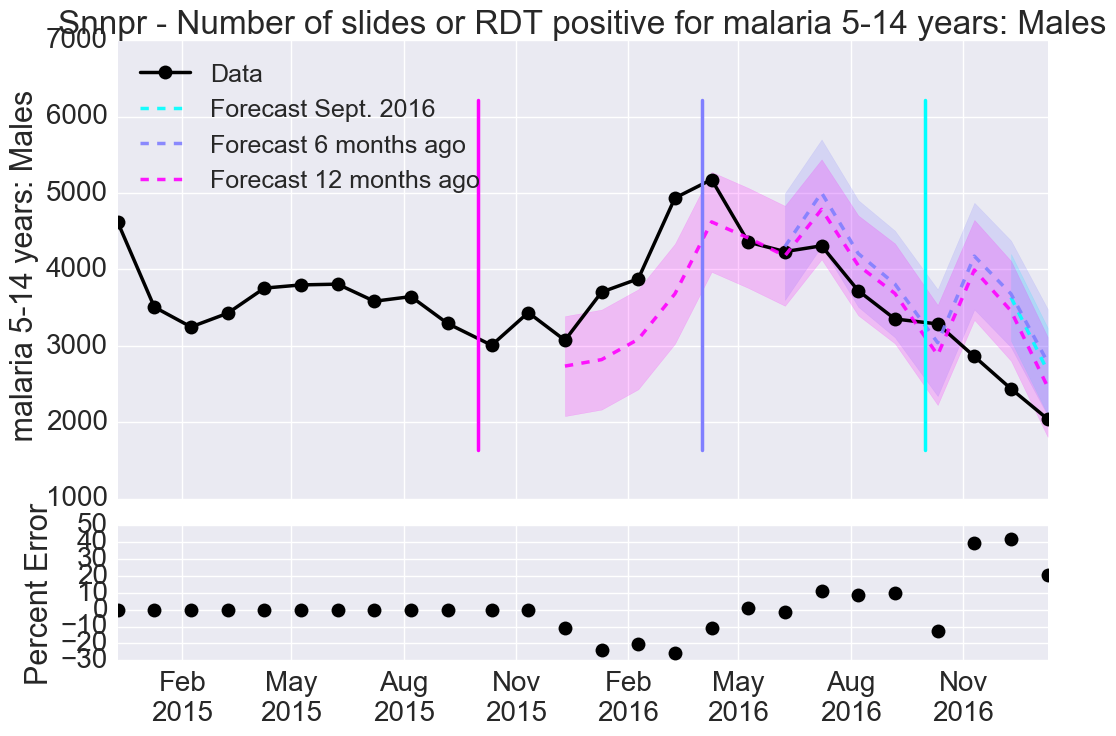

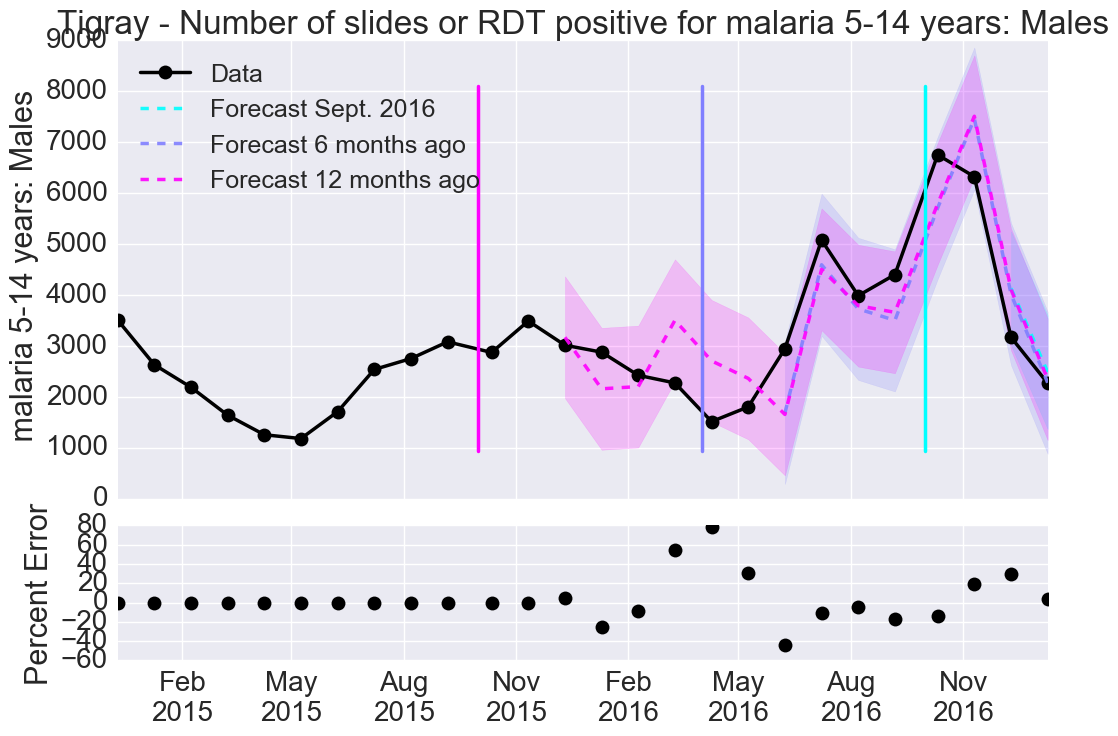

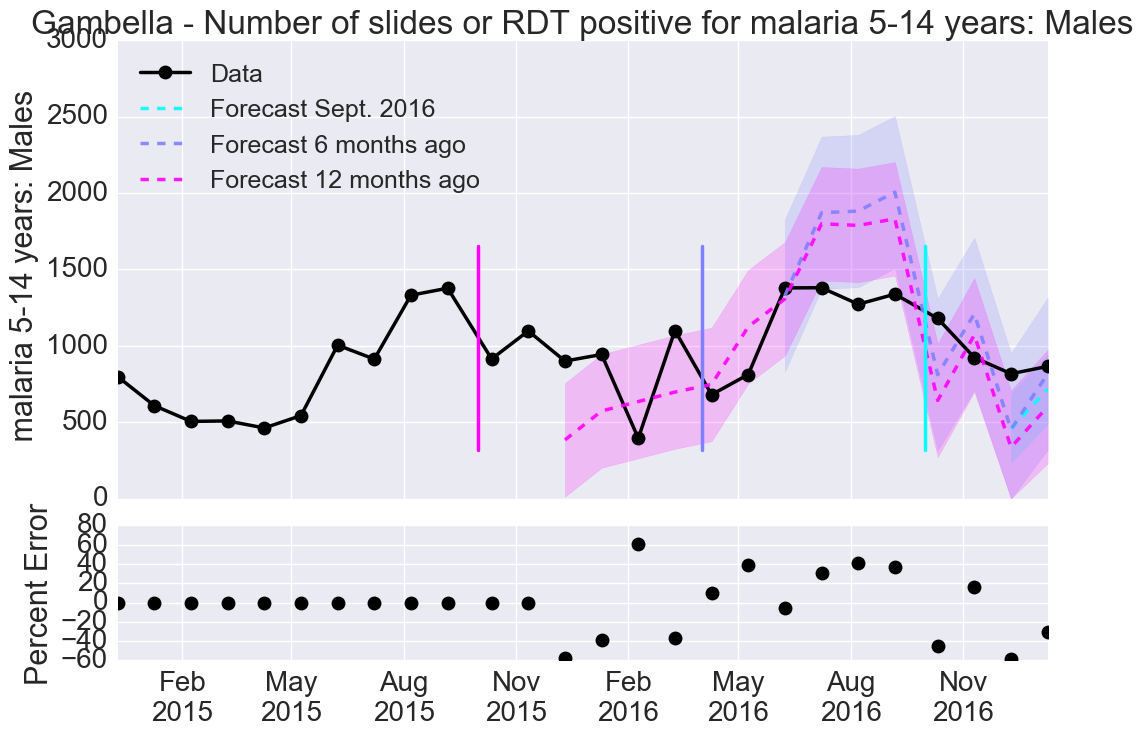

In [257]:
month = 1
df = dataframes[month-1].set_index(['Region'])
M = month
horz_lines = [(2016, 12 - (M-1)), (2016, 6 - (M-1)), (2015, 12 - (M-1)), (2015, 6 - (M-1))][:len(PRED_SHIFTS)]
training_end = (end_date.year, end_date.month - 1)
pred_text = ['Forecast Sept. 2016', 'Forecast 6 months ago', 'Forecast 12 months ago']

for region in regions:
    for indicator in indicators[2:3]:
        to_plot, predict_plot, RMSE_n = plot_testings_nation(df.loc[region], \
                        indicator, date_type='Real_Date', val_name='val',\
                        pred_name = 'prediction', pred_shifts=PRED_SHIFTS, training_end = training_end,  \
                        horz_lines = horz_lines, cf_band=True, cmap=cm.cool, \
                        title= '%s - %s' % (region.title(), indicator), pred_text=pred_text)
        #plt.savefig('%s/%s_%s.png' % (savedir, region, indicator))

<h1> Can loop through all the dataframes, each one is a different number of months forward </h1>

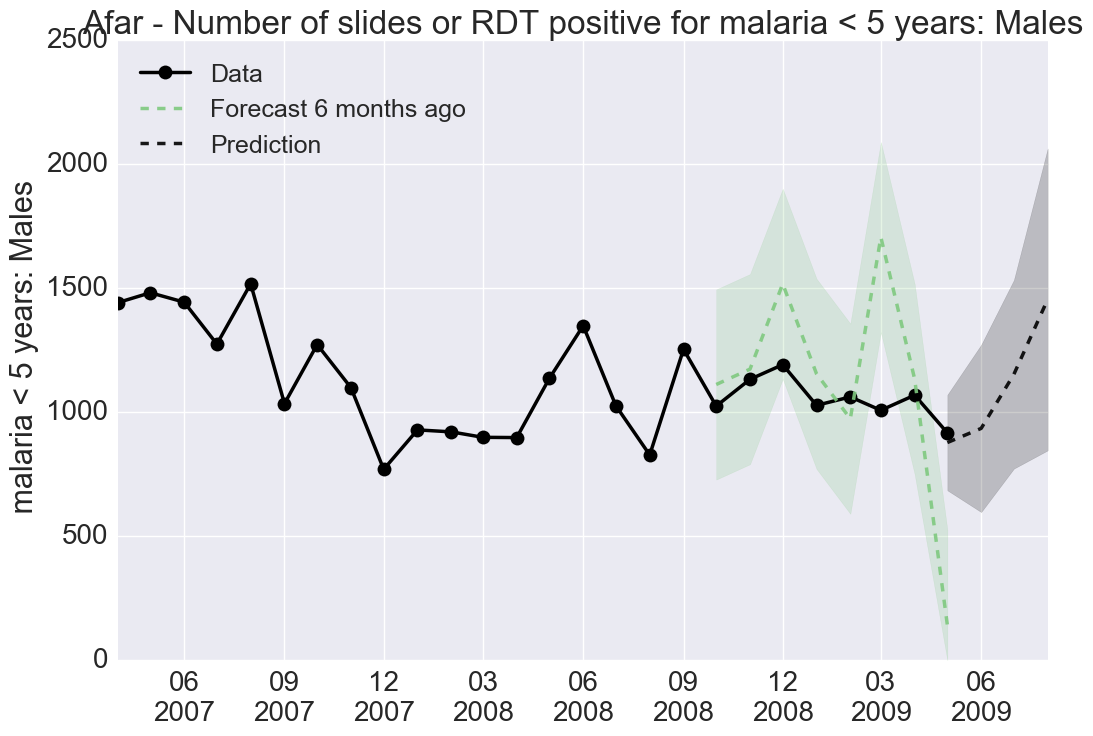

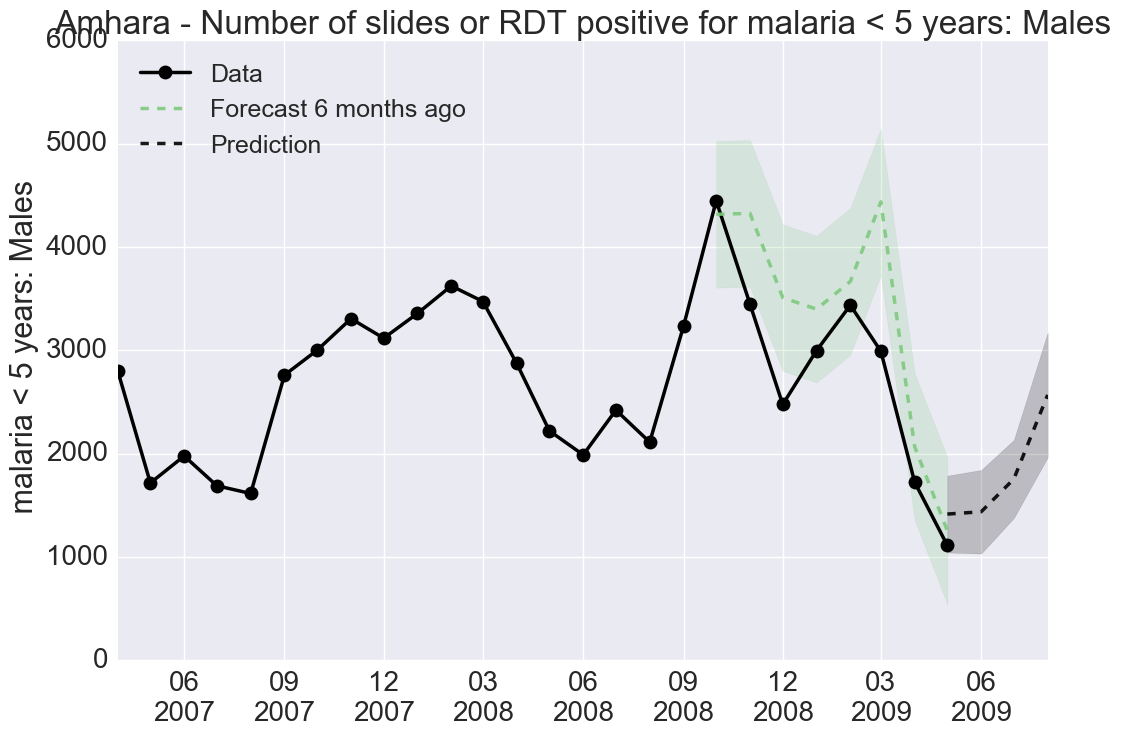

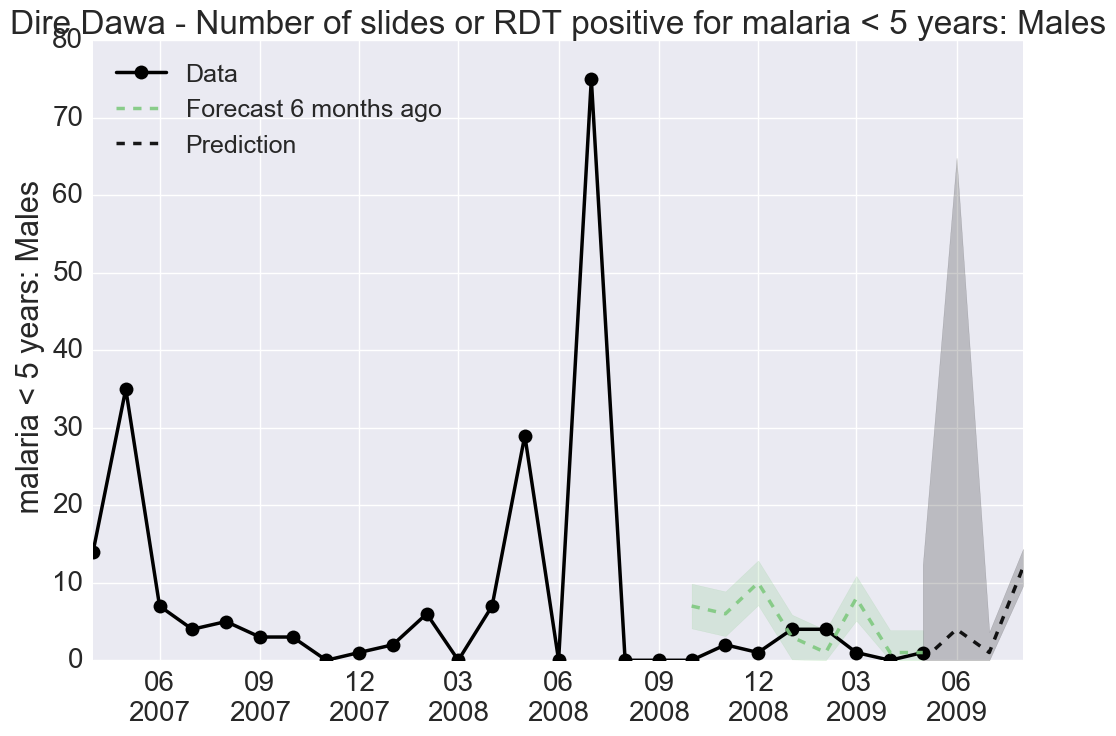

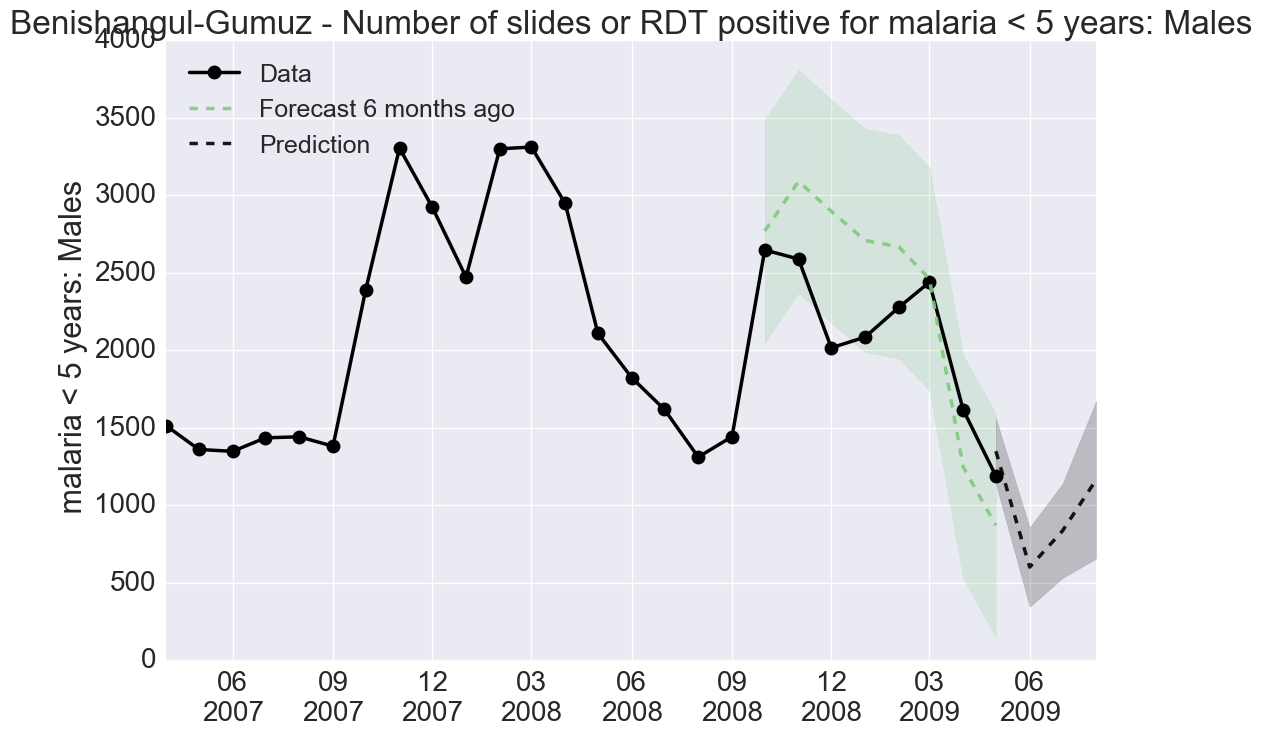

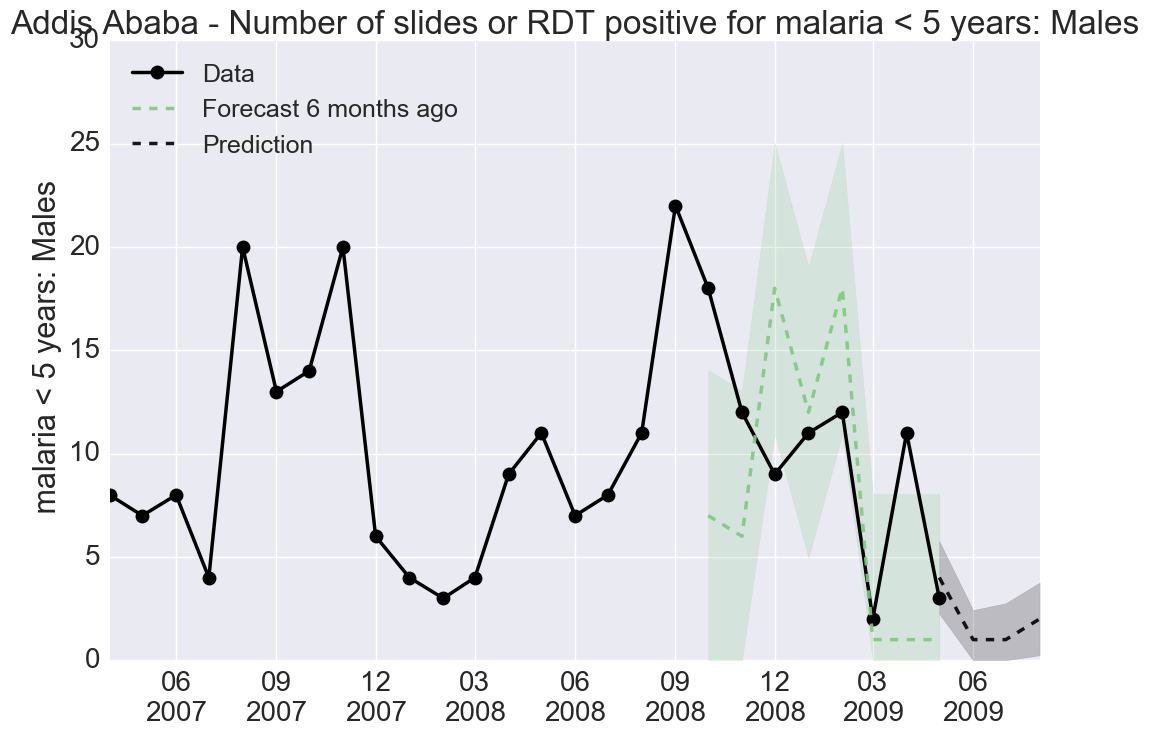

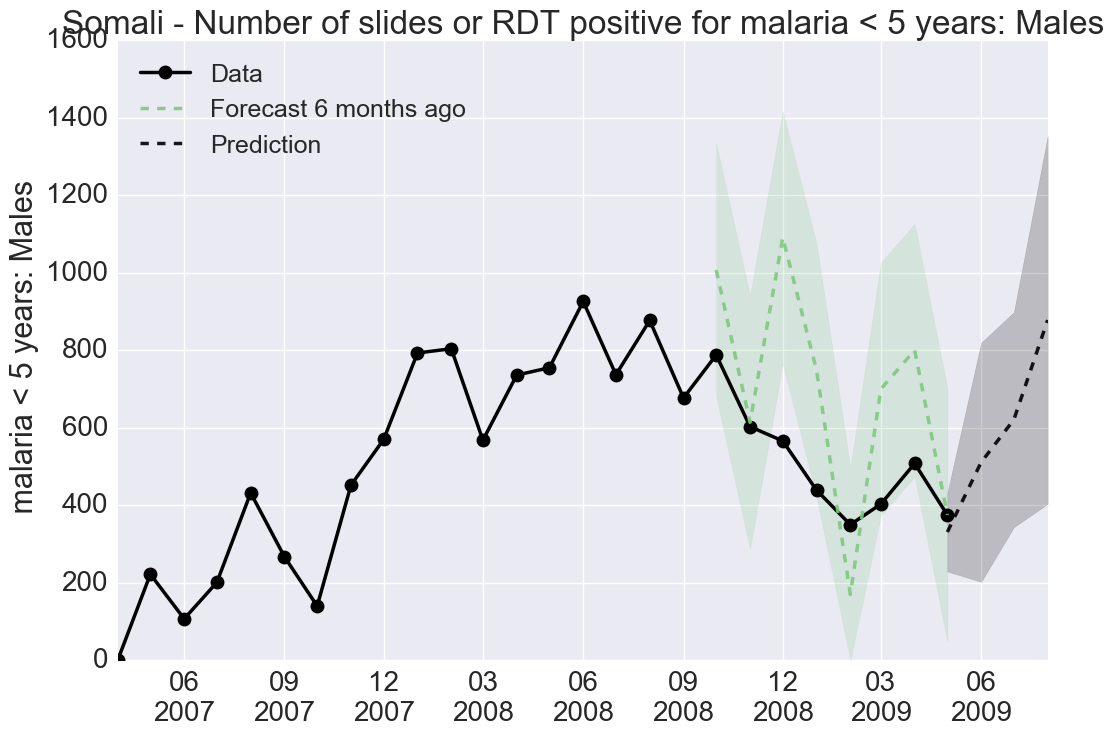

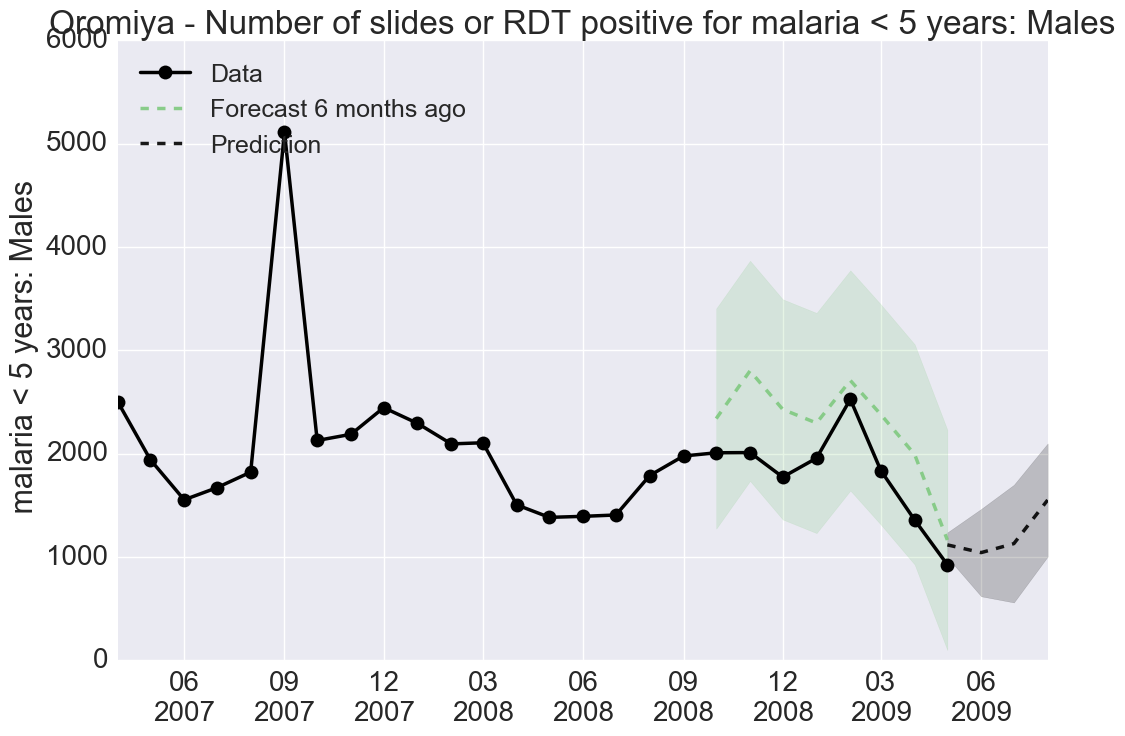

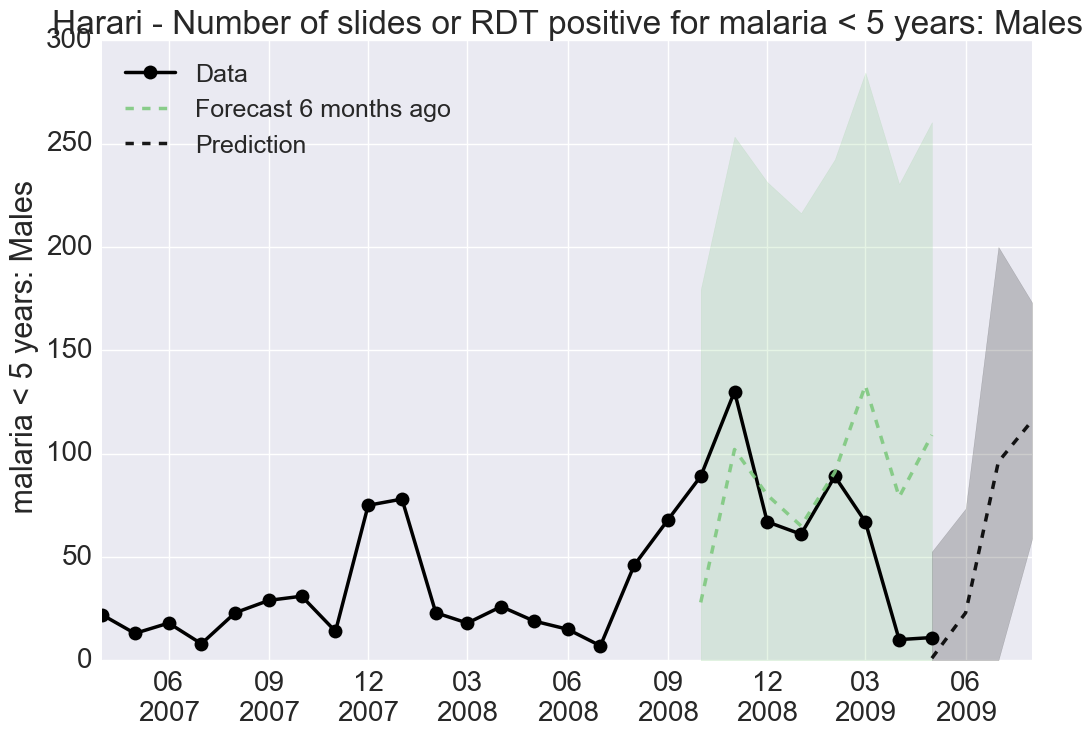

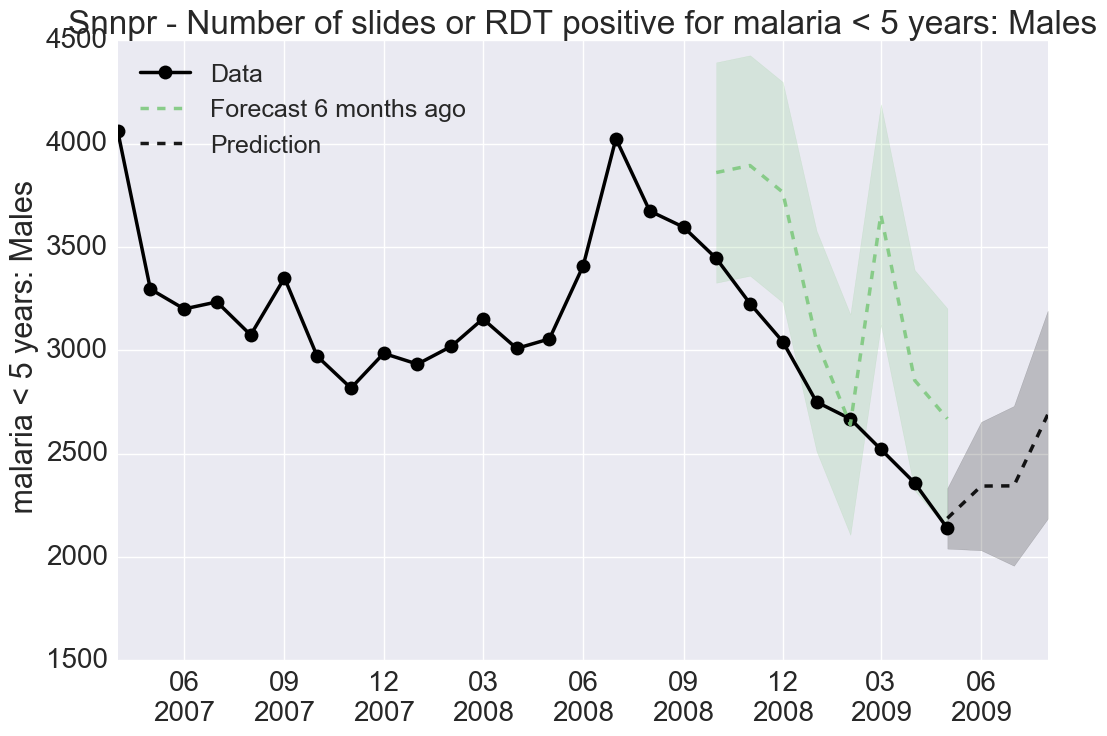

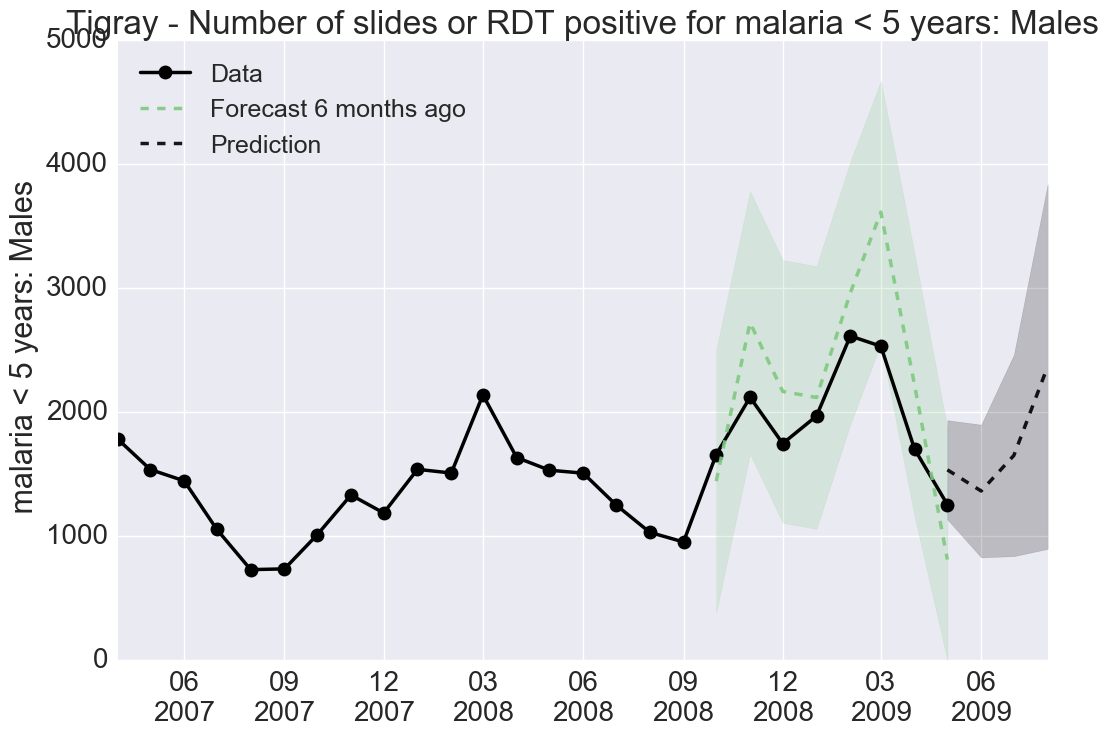

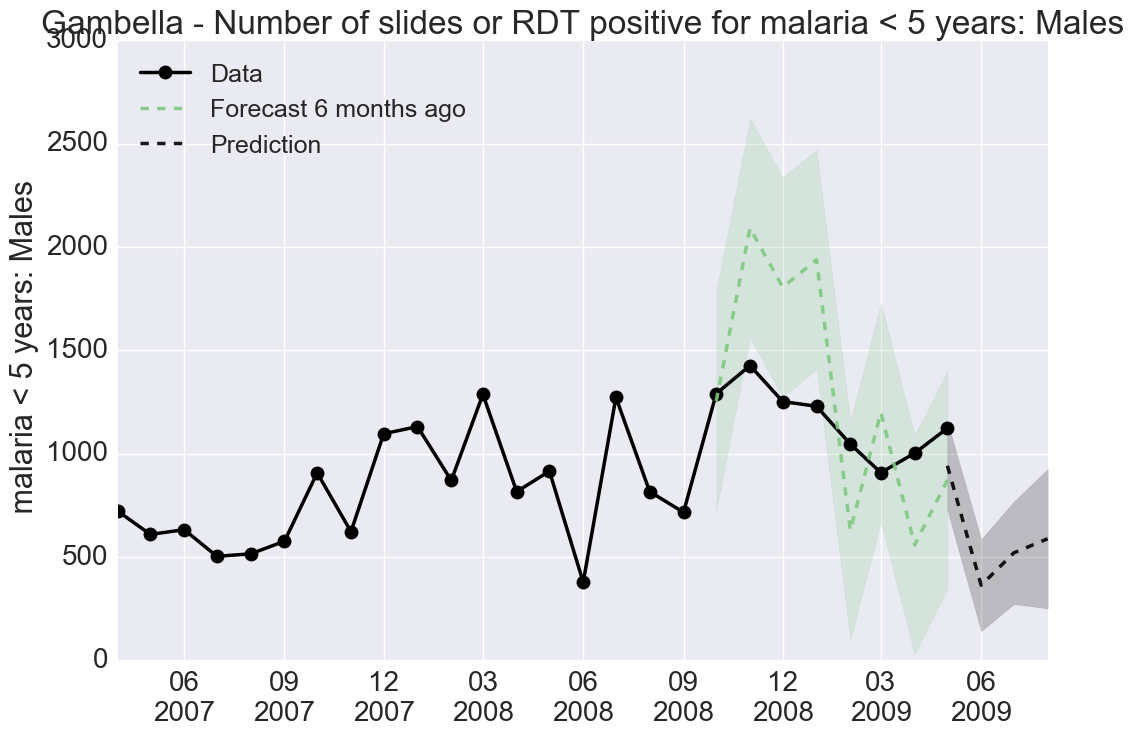

In [258]:
for region in regions:
    for indicator in indicators[:1]:
        a = plot_test_and_forecast(df.loc[region], prediction_df.loc[region], indicator, pred_shifts=PRED_SHIFTS[1:2], \
                                   training_end = training_end, cf_band=True, \
                                  title= '%s - %s' % (region.title(), indicator), pred_text=pred_text[1:2])

<h1> Plot results </h1>

In [148]:
# Plotting code
from plot_util import *

In [214]:
def plot_testings_nation(dataframe, indicator, date_type='E_Date', val_name='val', pred_name = 'prediction', \
                         pred_shifts = [0], training_end = (2008, 1), horz_lines = [(2007,1)], ylab=None, cf_band=False, \
                         cmap = pylab.cm.Accent, title = 'National', pred_text=None):
    # Setup colors for forecasts:
    start, stop=0, 1
    cm_subsection = np.linspace(start, stop, len(pred_shifts))
    colors = [cmap(x) for x in cm_subsection]
    
    # Plot the indicator values
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby([date_type])[val_name].sum()
    ylab_text = indicator.split('for')[-1]
    
    fig=pylab.figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

    plt.subplot2grid((4,1), (0,0), rowspan=3)
    x, y = pd_proper_dateformat(to_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='Data',)
    plt.title(title)
    
    # Plot the predictions
    for i, mshift in enumerate(pred_shifts):
        # add postfix to prediction name
        date_min = pd.datetime(training_end[0], training_end[1], 1) - pd.offsets.relativedelta(months=mshift)
        pred_str = pred_name
        if mshift > 0:
            pred_str = '%s_m_%s' % (pred_name, mshift)
        predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) \
            & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])[pred_str].sum()
        pred_lab_text = pred_str
        xp, yp = pd_proper_dateformat(predict_plot)
        #add custom labels
        if pred_text:
            plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_text[i], alpha = 0.9)
        else:
            plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_str, alpha = 0.9)
        # Add 1 sigma region:
        if cf_band:
            rmse = dataframe.loc[(dataframe['Indicator'] == indicator) \
                & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])['rmse'].mean()
            yp_upper = yp + np.mean(yp) * rmse
            yp_lower = [max(val, 0) for val in yp - np.mean(yp) * rmse]
            plt.fill_between(xp, yp_lower, yp_upper, color = colors[i], alpha = 0.2, interpolate=True)
            #print predict_upper
        
    if ylab:
        pylab.ylabel(ylab)
    else:
        pylab.ylabel(ylab_text)
        
    #pylab.xlabel('Date')
    pylab.legend(loc='upper left', numpoints=1, fontsize=18)
    ax = pylab.gca()
    # Remove x labels
    ax.tick_params(labelbottom='off')
    #ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%m-%Y'))
    #ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%m\n%Y'))
    
    # Add horizontal lines:
    for i, horz_line in enumerate(horz_lines):
        plt.plot_date(['%s-%s-01' % horz_line, '%s-%s-01' % horz_line],[to_plot.min()*0.8, to_plot.max()*1.2],\
                      '-', color = colors[i])
    
    plt.subplot2grid((4,1), (3,0))
    
    #RMSE_n = np.mean(np.sqrt((predict_plot - to_plot)**2) / to_plot)
    RMSE_n = np.sqrt( np.mean((predict_plot - to_plot)**2) ) / np.mean(to_plot)
    x, y = pd_proper_dateformat( ((predict_plot - to_plot) * 100 / to_plot).replace(np.nan,0) )

    plt.plot_date(x, y, '.', color='k', markersize=20, label='percent error',)
    #pylab.legend(loc='upper right', numpoints=1,fontsize=12)
    #plt.text(max(x), max(y), 'Norm RMSE = %s' % RMSE_n *100)
    
    pylab.ylabel('Percent Error')
    ax = pylab.gca()
    ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%b\n%Y'))
    #ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%m-%Y'))
    #pylab.xlabel('Date')
    
    return to_plot, predict_plot, RMSE_n

In [248]:
def plot_test_and_forecast(dataframe, df_predict, indicator, date_type='E_Date', val_name='val', pred_name = 'prediction', \
                         pred_shifts = [0], training_end = (2008, 1), horz_lines = [(2007,1)], ylab=None, cf_band=False, \
                         cmap = pylab.cm.Accent, title = 'National', pred_text=None):
    # Setup colors for forecasts:
    start, stop = 0, 1
    cm_subsection = np.linspace(start, stop, len(pred_shifts))
    colors = [cmap(x) for x in cm_subsection]
    
    # Plot the indicator values
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby([date_type])[val_name].sum()
    ylab_text = indicator.split('for')[-1]
    
    fig=pylab.figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

    x, y = pd_proper_dateformat(to_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='Data',)
    plt.title(title)
    
    # Plot the predictions
    for i, mshift in enumerate(pred_shifts):
        # add postfix to prediction name
        date_min = pd.datetime(training_end[0], training_end[1], 1) - pd.offsets.relativedelta(months=mshift)
        pred_str = pred_name
        if mshift > 0:
            pred_str = '%s_m_%s' % (pred_name, mshift)
        predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) \
            & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])[pred_str].sum()
        pred_lab_text = pred_str
        xp, yp = pd_proper_dateformat(predict_plot)
        #add custom labels
        if pred_text:
            plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_text[i], alpha = 0.9)
        else:
            plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_str, alpha = 0.9)
        # Add 1 sigma region:
        if cf_band:
            # TO DO: fix if national level
            rmse = dataframe.loc[(dataframe['Indicator'] == indicator) \
                & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])['rmse'].mean()
            yp_upper = yp + np.mean(yp) * rmse
            yp_lower = [max(val, 0) for val in yp - np.mean(yp) * rmse]
            plt.fill_between(xp, yp_lower, yp_upper, color = colors[i], alpha = 0.2, interpolate=True)
        
    if ylab:
        pylab.ylabel(ylab)
    else:
        pylab.ylabel(ylab_text)
        
    #pylab.xlabel('Date')
    ax = pylab.gca()
    # Remove x labels
    #ax.tick_params(labelbottom='off')
    ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%m\n%Y'))
    
    if len(horz_lines) > 1:
        for i, horz_line in enumerate(horz_lines):
            plt.plot_date(['%s-%s-01' % horz_line, '%s-%s-01' % horz_line],[to_plot.min()*0.8, to_plot.max()*1.2],\
                          '-', color = colors[i])
    
    # Plot forecasts
    predict_plot = df_predict.loc[(df_predict['Indicator'] == indicator) & (df_predict[date_type] > date_min)]\
        .reset_index().groupby([date_type])[pred_name].sum()
    pred_lab_text = 'prediction'
    xp, yp = pd_proper_dateformat(predict_plot)
    plt.plot_date(xp, yp, '--', color='k', markersize=20, label='Prediction', alpha = 0.9)
    if cf_band:
        rmse = df_predict.loc[(df_predict['Indicator'] == indicator) & (df_predict[date_type] > date_min)]\
        .reset_index().groupby([date_type])['rmse'].mean()
        yp_upper = yp + np.mean(yp) * rmse
        yp_lower = [max(val, 0) for val in yp - np.mean(yp) * rmse]
        plt.fill_between(xp, yp_lower, yp_upper, color = 'black', alpha = 0.2, interpolate=True)

    pylab.legend(loc='upper left', numpoints=1, fontsize=18)
    
    return to_plot, predict_plot, RMSE_n


<h1> One month prediction sanity check </h1>

In [94]:
[(v1, v2) for v1, v2 in zip(Preds_all[['prediction', 'rmse']].values, \
        DF_shift_all[DF_shift_all['E_Date'] > end_date][['prediction', 'rmse']].values)]

[(array([ 4.        ,  0.88003752]), array([ 3.        ,  0.88003752])),
 (array([ 2.        ,  0.81978195]), array([ 2.        ,  0.81978195])),
 (array([ 15.        ,   0.80707737]), array([ 15.        ,   0.80707737])),
 (array([ 9.        ,  0.89611085]), array([ 9.        ,  0.89611085])),
 (array([  1.50000000e+02,   1.43218265e-01]),
  array([  1.50000000e+02,   1.43218265e-01])),
 (array([ 74.        ,   0.24790809]), array([ 74.        ,   0.24790809])),
 (array([ 0.        ,  2.90258463]), array([ 0.        ,  2.90258463])),
 (array([ 1.        ,  0.39849979]), array([ 1.        ,  0.39849979])),
 (array([ 2.        ,  0.65755801]), array([ 2.        ,  0.65755801])),
 (array([ 0.      ,  0.609014]), array([ 0.      ,  0.609014])),
 (array([ 22.        ,   0.58304454]), array([ 22.        ,   0.58304454])),
 (array([ 14.        ,   0.71278011]), array([ 14.        ,   0.71278011])),
 (array([ 1.        ,  0.87455957]), array([ 1.        ,  0.87455957])),
 (array([ 1.        ,

In [45]:
last_rows = DF_shift_all[DF_shift_all['E_Date'] > end_date].reset_index()
last_rows[['E_Date', 'val', 'sg_val', 'prediction', 'prediction_m_6', 'rmse']]

E_Date     val        sg_val  prediction  prediction_m_6      rmse
0  2009-05-01     3.0      5.672727           3               0  0.880038
1  2009-05-01     2.0      1.915152           2               1  0.819782
2  2009-05-01    18.0     13.127273          15              12  0.807077
3  2009-05-01     9.0      9.006061           9               6  0.896111
4  2009-05-01   119.0    103.848485         150             165  0.143218
5  2009-05-01    45.0     53.339394          74              79  0.247908
6  2009-05-01     1.0      0.151515           0               3  2.902585
7  2009-05-01     0.0      0.533333           1               3  0.398500
8  2009-05-01     3.0      2.078788           2               5  0.657558
9  2009-05-01     0.0      0.327273           0               3  0.609014
10 2009-05-01    24.0     22.078788          22              24  0.583045
11 2009-05-01    12.0     14.272727          14              16  0.712780
12 2009-05-01    11.0      2.157576           1               1  0.874560
13 2009-05-01     6.0      1.000000           1               1  0.892108
14 2009-05-01    32.0     13.466667          18               1  0.670499
15 2009-05-01    23.0     14.909091           8               1  0.791974
16 2009-05-01    88.0     70.739394          86              31  0.355917
17 2009-05-01    55.0     40.212121          50               1  0.464283
18 2009-05-01   917.0    964.387879         878             882  0.174361
19 2009-05-01   814.0    833.490909         754             756  0.146303
20 2009-05-01  1047.0   1101.769697        1008            1013  0.167462
21 2009-05-01   900.0    951.763636         873             875  0.161877
22 2009-05-01  1451.0   1529.339394        1442            1445  0.181105
23 2009-05-01  1366.0   1453.484848        1370            1372  0.201638
24 2009-05-01  1111.0   1290.442424        1415            1354  0.206999
25 2009-05-01   899.0   1182.745455        1290            1234  0.215069
26 2009-05-01  2197.0   2642.242424        2858            2774  0.217476
27 2009-05-01  1550.0   1908.993939        2039            1975  0.218494
28 2009-05-01  9107.0  10348.193939       11676           11338  0.172112
29 2009-05-01  3857.0   4407.139394        4607            4521  0.192180
..        ...     ...           ...         ...             ...       ...
36 2009-05-01   375.0    407.521212         331             355  0.173888
37 2009-05-01   377.0    422.890909         347             371  0.218719
38 2009-05-01   489.0    459.921212         390             413  0.186675
39 2009-05-01   434.0    433.024242         361             385  0.208012
40 2009-05-01   520.0    472.939394         402             425  0.253843
41 2009-05-01   462.0    440.793939         369             392  0.223437
42 2009-05-01   925.0   1049.860606        1117            1080  0.099297
43 2009-05-01   795.0    922.490909         968             936  0.094150
44 2009-05-01  1283.0   1400.333333        1513            1465  0.080662
45 2009-05-01  1091.0   1184.066667        1271            1229  0.088111
46 2009-05-01  3073.0   3199.181818        3438            3359  0.081193
47 2009-05-01  2078.0   2399.800000        2547            2489  0.099807
48 2009-05-01  2139.0   2167.557576        2187            2199  0.061353
49 2009-05-01  1812.0   1846.769697        1869            1881  0.077485
50 2009-05-01  2041.0   2022.218182        2078            2082  0.078936
51 2009-05-01  1800.0   1817.866667        1855            1864  0.090752
52 2009-05-01  4167.0   4043.048485        4104            4102  0.030525
53 2009-05-01  3778.0   3821.187879        3841            3848  0.053886
54 2009-05-01  1256.0   1380.696970        1536            1410  0.231307
55 2009-05-01  1057.0   1185.145455        1323            1201  0.226078
56 2009-05-01  2265.0   2526.751515        2878            2709  0.245844
57 2009-05-01  1631.0   1860.315152        2102            1957  0.239804
58 2009-05-

In [ ]:
prediction_dfs.append(DF_shift_all[DF_shift_all['E_Date'] > end_date].reset_index())